In [10]:
import pandas as pd
from pathlib import Path

xlsx_path = Path("../data/raw/search_index_raw.xlsx")
df = pd.read_excel(xlsx_path, header=None)
df.head()


C:\Users\hwayo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,0,1,2,3,4,5,6,7,8,9
0,url,http://datalab.naver.com/keyword/trendResult.n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,주제,통검,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,범위,합계,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,기간,주간 : 2022-01 ~ 2025-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,성별,"전체(여성,남성)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 윈도우: 맑은 고딕
rcParams['font.family'] = 'Malgun Gothic'
# 한글 사용 시 마이너스 부호 깨짐 방지
rcParams['axes.unicode_minus'] = False

In [11]:
import pandas as pd
from pathlib import Path

xlsx_path = Path("../data/raw/search_index_raw.xlsx")

# 0) 엑셀을 헤더 없이 통째로 읽음 (모든 셀 값 유지)
raw = pd.read_excel(xlsx_path, sheet_name=0, header=None)

# 1) 헤더 줄(‘날짜, 롬앤, 날짜, 클리오…’) 위치 자동 탐색
#   - '날짜'라는 문자열이 들어있는 첫 번째 행을 헤더 줄로 간주
cand = raw.index[raw.apply(lambda r: r.astype(str).str.strip().eq("날짜").any(), axis=1)]
assert len(cand) > 0, "헤더(‘날짜’) 줄을 찾지 못했습니다. 파일 스크린샷을 보여주세요."
header_row = int(cand.min())

header = raw.iloc[header_row].astype(str).str.strip()
data = raw.iloc[header_row+1:].reset_index(drop=True).copy()

# 2) ‘날짜-브랜드-날짜-브랜드…’ 패턴에 맞춰 컬럼 쌍 구성
pairs = []
n_cols = data.shape[1]
for i in range(0, n_cols, 2):
    date_col = i
    val_col = i + 1
    if val_col >= n_cols:
        continue  # 짝이 없는 마지막 열이면 스킵

    date_head = str(header.iloc[date_col]).strip()
    brand_head = str(header.iloc[val_col]).strip()

    # 날짜/브랜드 쌍만 사용 (‘날짜’ 아닌 건 제외)
    if date_head != "날짜":
        continue
    if brand_head in ("", "Unnamed:"):
        continue

    # 3) 개별 브랜드의 날짜-값 추출
    tmp = data[[date_col, val_col]].copy()
    tmp.columns = ["date", "search_index"]
    tmp["brand_ko"] = brand_head
    pairs.append(tmp)

# 4) 모든 브랜드 병합
assert len(pairs) > 0, "브랜드 열을 찾지 못했습니다. 헤더 행에 브랜드명이 있는지 확인해주세요."
long = pd.concat(pairs, ignore_index=True)

# 5) 타입 정리
long["date"] = pd.to_datetime(long["date"], errors="coerce")
long = long.dropna(subset=["date"])
long["search_index"] = pd.to_numeric(long["search_index"], errors="coerce")

# 6) 브랜드 한–영 매핑 (없으면 원문 유지)
ko2en = {"롬앤":"romand","클리오":"clio","에뛰드":"etude","이니스프리":"innisfree","닥터자르트":"drjart"}
long["brand"] = long["brand_ko"].map(lambda x: ko2en.get(str(x).strip(), str(x).strip()))

# 7) 저장
out_path = Path("../data/processed/search_index.csv")
long.to_csv(out_path, index=False, encoding="utf-8")
print(f"✅ 저장 완료: {out_path}")
display(long.head(10))


✅ 저장 완료: ..\data\processed\search_index.csv


C:\Users\hwayo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,search_index,brand_ko,brand
0,2022-01-03,10.12279,롬앤,romand
1,2022-01-10,10.59199,롬앤,romand
2,2022-01-17,11.49582,롬앤,romand
3,2022-01-24,14.63042,롬앤,romand
4,2022-01-31,16.68996,롬앤,romand
5,2022-02-07,11.60736,롬앤,romand
6,2022-02-14,10.46841,롬앤,romand
7,2022-02-21,10.21810,롬앤,romand
8,2022-02-28,9.43733,롬앤,romand
9,2022-03-07,8.44133,롬앤,romand


In [22]:
import pandas as pd
from pathlib import Path

events = pd.DataFrame({
    "brand" : ["romand","clio","etude","innisfree","drjart"],
    "brand_ko" : ["롬앤","클리오","에뛰드","이니스프리","닥터자르트"],
    "event_date" : [ #모든 논란은 최초 기사 발행일로 선정
        "2025-09-01", #롬앤 구순염 논란
        "2024-09-20", #클리오 쿠션/트러블 논란
        "2018-03-19", #에뛰드 중금속 판매중지 논
        "2021-04-09", #이니스프리 종이병 논란
        "2021-04-12", #터자르트 제형 논란
    ]
})
events["event_date"] = pd.to_datetime(events["event_date"])

out = Path("../data/processed/brands.csv")
events.to_csv(out, index=False, encoding="utf-8")
print("저장 :", out)
events

저장 : ..\data\processed\brands.csv


,brand,brand_ko,event_date
0,romand,롬앤,2025-09-01
1,clio,클리오,2024-09-20
2,etude,에뛰드,2018-03-19
3,innisfree,이니스프리,2021-04-09
4,drjart,닥터자르트,2021-04-12


In [29]:
import pandas as pd
import re

# 문자열로 읽어오되, event_date가 비어있어도 에러 안 나도록
ev = pd.read_csv("../data/processed/brands.csv", dtype={"brand": str, "event_date": str})

def normalize_event_date(s):
    # None, NaN 처리
    if s is None or pd.isna(s):
        return pd.NaT

    s = str(s).strip()

    # YYYY-MM-DD
    if re.fullmatch(r"\d{4}-\d{2}-\d{2}", s):
        return pd.to_datetime(s, errors="coerce")

    # YYYY-MM  → 1일로 보정
    if re.fullmatch(r"\d{4}-\d{2}", s):
        return pd.to_datetime(s + "-01", errors="coerce")

    # YYYY  → 1월 1일로 보정
    if re.fullmatch(r"\d{4}", s):
        return pd.to_datetime(s + "-01-01", errors="coerce")

    # 다른 형식은 파서에 맡기고 실패 시 NaT
    return pd.to_datetime(s, errors="coerce")

# 함수 적용
ev["event_date"] = ev["event_date"].apply(normalize_event_date)


ev.to_csv("../data/processed/brands.csv", index=False, encoding="utf-8")

# 결과 확인
ev[["brand", "event_date"]]

,brand,event_date
0,romand,2025-09-01
1,clio,2024-09-20
2,etude,2018-03-19
3,innisfree,2021-04-09
4,drjart,2021-04-12


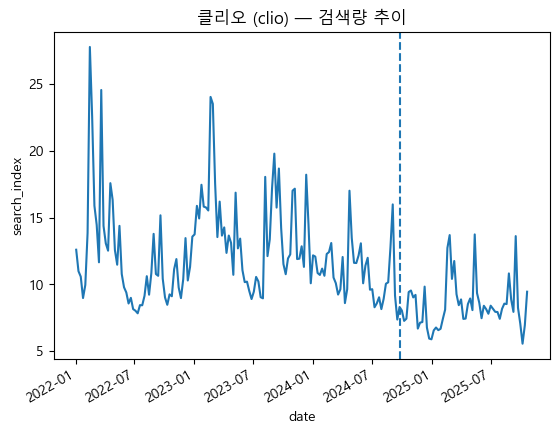

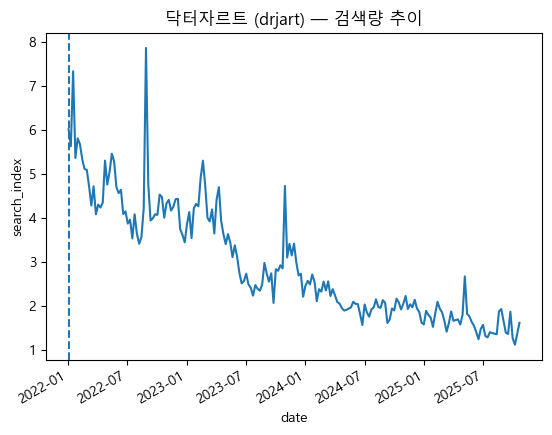

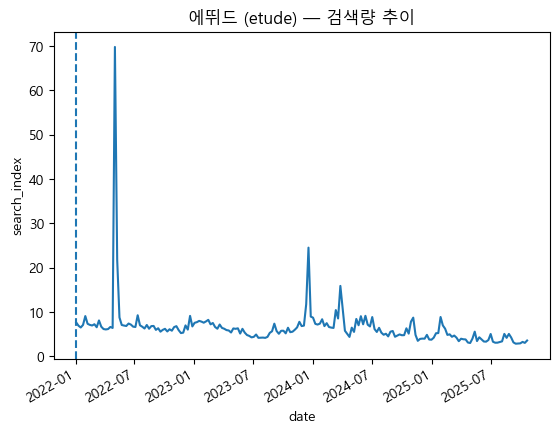

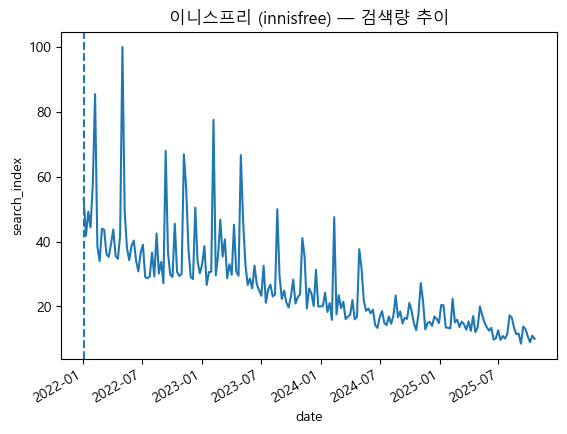

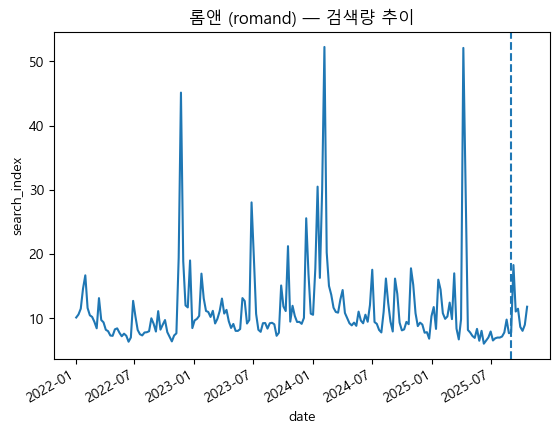

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

long = pd.read_csv("../data/processed/search_index.csv", parse_dates=["date"])
events = pd.read_csv("../data/processed/brands.csv", parse_dates=["event_date"])

# (윈도우) 한글 폰트
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

def snap_to_nearest(series, target):
    return series.iloc[(series - target).abs().argmin()]

for b, grp in long.groupby("brand"):
    ko = grp["brand_ko"].iloc[0]
    s = grp.sort_values("date")
    evt = events.loc[events["brand"]==b, "event_date"]
    evt = evt.iloc[0] if not evt.empty else None

    fig, ax = plt.subplots()
    ax.plot(s["date"], s["search_index"])

    if pd.notna(evt):
        ax.axvline(snap_to_nearest(s["date"], evt), linestyle="--")

    ax.set_title(f"{ko} ({b}) — 검색량 추이")
    ax.set_xlabel("date"); ax.set_ylabel("search_index")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    plt.show()
